#  [Esri Data Science Challenge 2019](https://www.hackerearth.com/challenges/hiring/esri-data-science-challenge-2019/)





# Problem Statement


Given an aerial image, we have to identify two objects: Pool and Car.

Now Car is present in almost all Object Detection datasets, but Pool may be or may not be supported.

Hence, we need to fine tune pretrained models on given dataset.

---

# Dataset

Dataset :  [Link](https://s3-ap-southeast-1.amazonaws.com/he-public-data/ESRI%20DATAc8fe593.zip)

We are given 3748 training images and 2703 testing images each may contain two objects Pool and Car.

## Approach


We will use Faster R-CNN models using [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) provided by tensorflow team. (*Thanks Google!*)

There are so many pretrained models provided by Object Detection API, you can look it up [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).


Using Object Detection API is quite tricky or simple if you get all steps right by following steps suggested in [this documentation](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html) ,

1. **Creating Label Map**

TensorFlow requires a label map, which namely maps each of the used labels to an integer values. This label map is used both by the training and detection processes and saving it as `label_map.pbtxt`.

```python

item {
    id: 1
    name: 'Car'
}

item {
    id: 2
    name: 'Pool'
}
```

2. **Creating TF Record**


There are two steps in doing so:

 - Converting the individual *.xml files to a unified *.csv file for each dataset.
 - Converting the *.csv files of each dataset to *.record files (TFRecord format).

The code is given below. After this we obtain two files train.record and test.record.
 

3. **Configuring Training Pipeline**

Now the most important part of training, creating a .config file corresponding whatever pretrained model we choose.

Training for considerable long time till we obtain an loss something in range of 0.08xx or less should produce excellent results.

---

# Problems in Training

Training in colab proved to be significantly harder. As there was the error of running !python vs %run.

- !python was hard to get working
- %run saved model every 1000 steps and gave error, hence we need to `Restart runtime` and run the model again.(*Me, I trained the model for 20,000 steps, calculate how many times I restarted?*)

---

# Results

Oh, they were pretty. I mean so cool!

Scroll down to the Inference section and see for yourself.


## Download and unzip training and test data


In [0]:
!apt-get install -y -qq protobuf-compiler python-pil python-lxml
!git clone https://github.com/tensorflow/models.git
!apt-get -qq install libprotobuf-java protobuf-compiler
!cp -R models/research/object_detection/ object_detection/
!protoc object_detection/protos/*.proto --python_out=.

Cloning into 'models'...
remote: Enumerating objects: 24636, done.
remote: Total 24636 (delta 0), reused 0 (delta 0), pack-reused 24636
Receiving objects: 100% (24636/24636), 507.84 MiB | 14.38 MiB/s, done.
Resolving deltas: 100% (14378/14378), done.
Checking out files: 100% (2858/2858), done.


In [0]:
% cd models/research/
! protoc object_detection/protos/*.proto --python_out=.
% cd /content/

/content/models/research
/content


In [0]:
import sys
sys.path.append('/content/models/research/slim')
%set_env PYTHONPATH=/content/models/research:/content/models/research/slim

env: PYTHONPATH=/content/models/research:/content/models/research/slim


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# training_data link
# https://drive.google.com/open?id=10ufE3VKG0mk7exnElmkNd_ouSNCj_skr

In [0]:
# test data link
# https://drive.google.com/open?id=1gNQhKZO_8SWWb8E_eBNUvjoQbfGwpw2r

In [0]:
! wget "https://s3-ap-southeast-1.amazonaws.com/he-public-data/ESRI%20DATAc8fe593.zip"

--2019-03-10 20:59:22--  https://s3-ap-southeast-1.amazonaws.com/he-public-data/ESRI%20DATAc8fe593.zip
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.36.5
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.36.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116582587 (111M) [binary/octet-stream]
Saving to: ‘ESRI DATAc8fe593.zip’

ESRI DATAc8fe593.zi 100%[===================>] 111.18M  47.6MB/s    in 2.3s    

2019-03-10 20:59:25 (47.6 MB/s) - ‘ESRI DATAc8fe593.zip’ saved [116582587/116582587]



In [0]:
!unzip 'ESRI DATAc8fe593.zip'

Archive:  ESRI DATAc8fe593.zip
 extracting: ESRI DATA/samplesubmission.zip  
 extracting: ESRI DATA/test_data_images.zip  
 extracting: ESRI DATA/training_data.zip  


In [0]:
import os
os.mkdir('data')

In [0]:
!unzip --qq  'ESRI DATA/training_data.zip' -d 'data'
!unzip --qq  'ESRI DATA/test_data_images.zip' -d 'data'

In [0]:
ls /content/data/training_data/

images/  labels/


In [0]:
ls /content/data/test_data_images/

images/


In [0]:
!ls -lR /content/data/training_data/images/*.jpg | wc -l
!ls -lR /content/data/test_data_images/images/*.jpg | wc -l

3748
2703


## Read Pascal VOC labels for objects within images

In [0]:
from pathlib import Path
import xml.etree.ElementTree as ET

data_path = Path('/content/data')
train_path = data_path/'training_data'
test_path = data_path/'test_data_images'


#MULTIBOX_CSV = PATH/'bboxes.csv' # CSV file to use
sz = 224                         # size of images to be used
bs = 16                          # batch size
JPEGS = 'images'


def get_bbox_labels(imagefile, PATH):
    xmlfile = PATH / 'labels' / imagefile.name.replace(imagefile.suffix, '.xml')
    # print(xmlfile)
    tree = ET.parse(xmlfile)
    xmlroot = tree.getroot()

    bboxes  = []
    classes = []
    for child in xmlroot:
        if child.tag == 'object':
            xmin, ymin, xmax, ymax = float(child[1][0].text),float(child[1][1].text), float(child[1][2].text),float(child[1][3].text)
            # bboxes.append([xmin, ymin, xmax, ymax])
            bboxes.append([ymin, xmin, ymax, xmax])
            classes.append(child[0].text)


    return [bboxes, classes]

In [0]:
labelmap = {'1': 'Car', '2':'Pool'}

## Visualize Training Data

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def show_images_with_labels(images, PATH):
  for i,image in enumerate(images):  
    fig,ax = plt.subplots(1,1, figsize=(5,5))
    img = plt.imread(str(PATH/'images'/image))
    bbox = get_bbox_labels(Path(image), PATH)
    for i in range(len(bbox[1])): 
      rect = patches.Rectangle((bbox[0][i][1], bbox[0][i][0]),bbox[0][i][3]-bbox[0][i][1],bbox[0][i][2]-bbox[0][i][0],linewidth=2,edgecolor='w',facecolor='none') #top left(x1,y1) and width, height
      ax.text(bbox[0][i][1],bbox[0][i][0]-5, labelmap[bbox[1][i]], color='w')      
      ax.add_patch(rect)
    # Add the patch to the Axes
    ax.imshow(img)
    plt.grid(False)
    plt.show()    

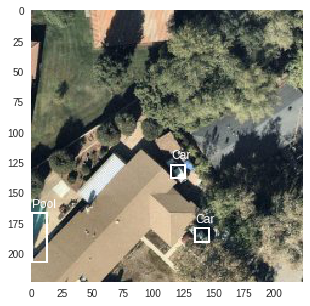

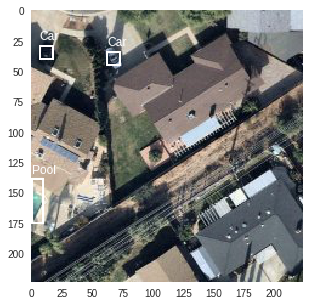

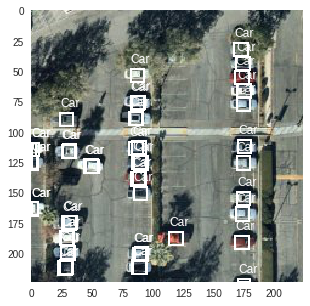

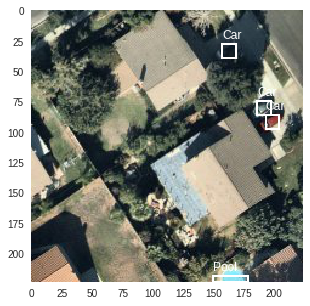

In [0]:
show_images_with_labels(['000001818.jpg', '000000342.jpg', '000003695.jpg', '000000143.jpg'], train_path)

## Visualize Test Data

In [0]:
def show_images(images, PATH):
  for image in images:
    fig,ax = plt.subplots(1,1, figsize=(5,5))
    img = plt.imread(str(PATH/'images'/image))
    ax.imshow(img)
    plt.grid(False)

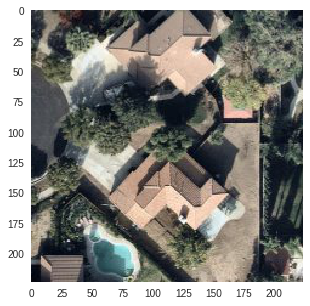

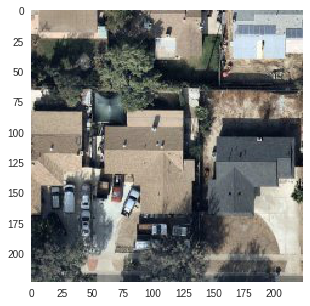

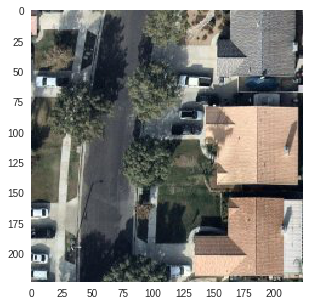

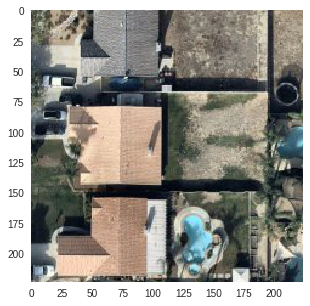

In [0]:
show_images(['000000241.jpg', '000000342.jpg', '000000142.jpg', '000000143.jpg'], test_path)

### Split 10 images from train to val

In [0]:
os.mkdir('/content/data/validation_data')
os.mkdir('/content/data/validation_data/images')
os.mkdir('/content/data/validation_data/labels')
os.mkdir('/content/data/weights')

In [0]:
import os
import random
import shutil

src = '/content/data/training_data/images'
dst = '/content/data/validation_data/images'

dirfiles = os.listdir(src)
myfiles = random.sample(dirfiles, 10)
count = len(myfiles)

for filename in myfiles:
    shutil.move(os.path.join(src, filename), dst)

In [0]:
src_label = '/content/data/training_data/labels'
dst_label = '/content/data/validation_data/labels'
for filename in os.listdir('/content/data/validation_data/images'):
    shutil.move(os.path.join(src_label, filename.split('.')[0] + '.xml'), dst_label)

In [0]:
! ls {dst_label}

000000248.xml  000000666.xml  000001154.xml  000001983.xml  000002598.xml
000000279.xml  000000670.xml  000001334.xml  000002037.xml  000002932.xml


In [0]:
!ls -lR /content/data/training_data/images/*.jpg | wc -l
!ls -lR /content/data/training_data/labels/*.xml | wc -l

!ls -lR /content/data/validation_data/images/*.jpg | wc -l
!ls -lR /content/data/validation_data/labels/*.xml | wc -l

!ls -lR /content/data/test_data_images/images/*.jpg | wc -l

3738
3738
10
10
2703


## Tensorflow Object Detection

In [0]:
'''
save label_map.pbtxt
item {
    id: 1
    name: 'Car'
}

item {
    id: 2
    name: 'Pool'
}

'''

import shutil
shutil.copy('label_map.pbtxt', 'data/')

'data/label_map.pbtxt'

In [0]:
"""
Converting *.xml to *.csv
Usage:
# Create train data:
python xml_to_csv.py -i [PATH_TO_IMAGES_FOLDER]/train -o [PATH_TO_ANNOTATIONS_FOLDER]/train_labels.csv

# Create test data:
python xml_to_csv.py -i [PATH_TO_IMAGES_FOLDER]/test -o [PATH_TO_ANNOTATIONS_FOLDER]/test_labels.csv
"""

import os
import glob
import pandas as pd
import argparse
import xml.etree.ElementTree as ET


def int_to_class(int_label):

    if int_label == '1':
        return 'Car'
    
    elif int_label == '2':
        return 'Pool'

def xml_to_csv(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines them in a single Pandas datagrame.

    Parameters:
    ----------
    path : {str}
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """

    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                    int(root.find('size')[0].text),
                    int(root.find('size')[1].text),
                    int_to_class(member[0].text),
                    float(member[1][0].text),
                    float(member[1][1].text),
                    float(member[1][2].text),
                    float(member[1][3].text)
                    )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [0]:
xml_df = xml_to_csv('data/training_data/labels')
xml_df.to_csv('data/train_labels.csv', index=None)
print('Successfully converted xml to csv.')

Successfully converted xml to csv.


In [0]:
xml_df = xml_to_csv('data/validation_data')
xml_df.to_csv('data/test_labels.csv', index=None)
print('Successfully converted xml to csv.')

Successfully converted xml to csv.


In [0]:
"""
Converting from *.csv to *.record

Usage:

# Create train data:
python generate_tfrecord.py --label=<LABEL> --csv_input=<PATH_TO_ANNOTATIONS_FOLDER>/train_labels.csv  --output_path=<PATH_TO_ANNOTATIONS_FOLDER>/train.record

# Create test data:
python generate_tfrecord.py --label=<LABEL> --csv_input=<PATH_TO_ANNOTATIONS_FOLDER>/test_labels.csv  --output_path=<PATH_TO_ANNOTATIONS_FOLDER>/test.record
"""


from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf
import sys

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict


def class_text_to_int(row_label):
    if row_label == 'Car':
      return 1
    elif row_label == 'Pool':
      return 2
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    # check if the image format is matching with your images.
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


In [0]:
writer = tf.python_io.TFRecordWriter('data/train.record')
path = os.path.join(os.getcwd(), 'data/training_data/images')
examples = pd.read_csv('data/train_labels.csv')
grouped = split(examples, 'filename')
for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())

writer.close()
output_path = os.path.join(os.getcwd(), 'data/train.record')
print('Successfully created the TFRecords: {}'.format(output_path))

Successfully created the TFRecords: /content/data/train.record


In [0]:
writer = tf.python_io.TFRecordWriter('data/test.record')
path = os.path.join(os.getcwd(), 'data/validation_data/images')
examples = pd.read_csv('data/test_labels.csv')
grouped = split(examples, 'filename')
for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())

writer.close()
output_path = os.path.join(os.getcwd(), 'data/test.record')
print('Successfully created the TFRecords: {}'.format(output_path))

Successfully created the TFRecords: /content/data/test.record


In [0]:
models = [#'ssd_mobilenet_v2_coco_2018_03_29' 
#        'ssd_inception_v2_coco_2018_01_28']
#         'faster_rcnn_inception_v2_coco_2018_01_28']  
#          'faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28'] 
#           'faster_rcnn_resnet101_kitti_2018_01_28', 
#           'faster_rcnn_nas_coco_2018_01_28']
#            'faster_rcnn_inception_resnet_v2_atrous_oid_2018_01_28']
#           'mask_rcnn_resnet101_atrous_coco_2018_01_28']
#             'faster_rcnn_resnet50_coco_2018_01_28']
           'faster_rcnn_resnet101_coco_2018_01_28']


In [0]:
import six.moves.urllib as urllib
import sys

def download_model(MODEL_NAME):
    MODEL_FILE = MODEL_NAME + '.tar.gz'
    DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    
for m in models:
  download_model(m)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  if sys.path[0] == '':


In [0]:
#model = 'faster_rcnn_inception_resnet_v2_atrous_oid'
#model ='faster_rcnn_inception_resnet_v2_atrous_coco'
#model = 'faster_rcnn_inception_v2_coco'
#model = 'faster_rcnn_resnet50_coco'
model = 'faster_rcnn_resnet101_coco'

In [0]:
!tar -xzvf '{model}_2018_01_28.tar.gz'

faster_rcnn_resnet101_coco_2018_01_28/
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.index
faster_rcnn_resnet101_coco_2018_01_28/checkpoint
faster_rcnn_resnet101_coco_2018_01_28/pipeline.config
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.data-00000-of-00001
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.meta
faster_rcnn_resnet101_coco_2018_01_28/saved_model/
faster_rcnn_resnet101_coco_2018_01_28/saved_model/saved_model.pb
faster_rcnn_resnet101_coco_2018_01_28/saved_model/variables/
faster_rcnn_resnet101_coco_2018_01_28/frozen_inference_graph.pb


In [0]:
import re

filename = f'/content/object_detection/samples/configs/{model}.config'
with open(filename) as f:
  s = f.read()

filename = f'/content/{model}.config'  
with open(filename, 'w') as f:
  s = re.sub('num_classes: 90', 'num_classes: 2', s)
  s = re.sub('iou_threshold: 0.6', 'iou_threshold: 0.3', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/content/faster_rcnn_resnet101_coco_2018_01_28/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt', '/content/data/label_map.pbtxt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_train.record-\?\?\?\?\?-of-00100', '/content/data/train.record', s)
  s = re.sub('batch_size: 24', 'batch_size: 32', s) 
  f.write(s)

In [0]:
# # # Load the TensorBoard notebook extension
%load_ext tensorboard.notebook
%tensorboard --logdir=/content/data/weights

In [0]:
%run /content/object_detection/model_main.py \
     --pipeline_config_path=/content/faster_rcnn_resnet101_coco.config \
     --model_dir=/content/data/new_weights \
     --alsologtostderr \
     --num_train_steps=100000 \
     --num_eval_steps=20


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Maybe overwriting train_steps: 100000
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Maybe overwriting load_pretrained: True
INFO:tensorflow:Ignoring config override key: load_pretrained
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to_tpu False
INFO:tensorflow:Using config: {'_model_dir': '/content/data/new_weights', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /content/data/new_weights/model.ckpt-20928
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 20928 into /content/data/new_weights/model.ckpt.
INFO:tensorflow:loss = 0.122594625, step = 20928
INFO:tensorflow:global_step/sec: 1.57232
INFO:tensorflow:loss = 0.45102894, step = 21028 (63.603 sec)
INFO:tensorflow:global_step/sec: 1.66854
INFO:tensorflow:loss = 0.2629018, step = 21128 (59.937 sec)
INFO:tensorflow:global_step/sec: 1.66645
INFO:tensorflow:loss = 0.16110352, step = 21228 (60.008 sec)
INFO:tensorflow:global_step/sec: 1.67449
INFO:tensorflow:loss = 0.12743789, step = 21328 (59.718 sec)
INFO:tensor

In [0]:
import os
lst = os.listdir('/content/data/new_weights')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')
last_model

'model.ckpt-9401.index'

In [0]:
last_model = 'model.ckpt-17979'

In [0]:
%run /content/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path='/content/{model}.config' \
    --trained_checkpoint_prefix=/content/data/new_weights/$last_model \
    --output_directory=/content/data/new_output_inference_graphs

In [0]:
! cp -R /content/data/new_weights/ "/content/drive/My Drive/Colab Notebooks/"

In [0]:
! cp -R /content/data/new_output_inference_graphs "/content/drive/My Drive/Colab Notebooks/"

## Inference

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import time
import random
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from object_detection.utils import ops as utils_ops
from PIL import Image
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
%matplotlib inline

# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.

PATH_TO_CKPT = '/content/data/new_output_inference_graphs' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/data', 'label_map.pbtxt')

NUM_CLASSES = 2

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/data/test_data_images/images'
#rnd_images = random.sample(os.listdir(PATH_TO_TEST_IMAGES_DIR), 5)
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, rnd_images[i]) for i in range(5) ]

test_images = os.listdir(PATH_TO_TEST_IMAGES_DIR)
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, test_images[i]) for i in range(len(test_images)) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


In [0]:
def inference_and_plot(detection_graph):
    with detection_graph.as_default():
      with tf.Session(graph=detection_graph) as sess:
        
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for image_path in TEST_IMAGE_PATHS:
            
            start_time = time.time()
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})

            end_time = time.time()
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=3)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.grid(visible=False)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(image_np)
            plt.show()
            
            print ('Time taken: ', (end_time-start_time))

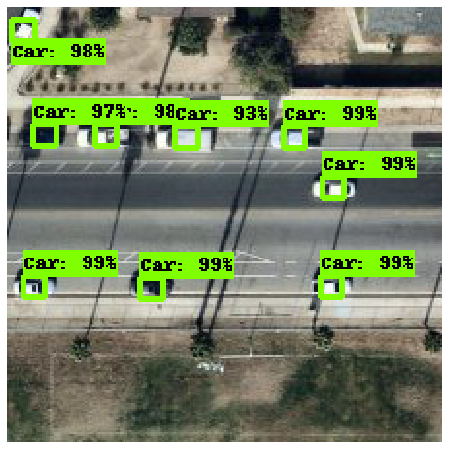

Time taken:  4.495909929275513


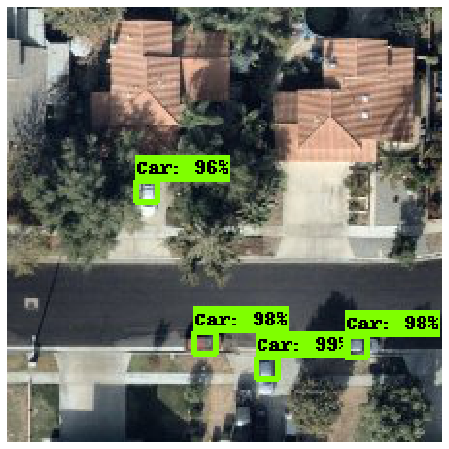

Time taken:  0.4336550235748291


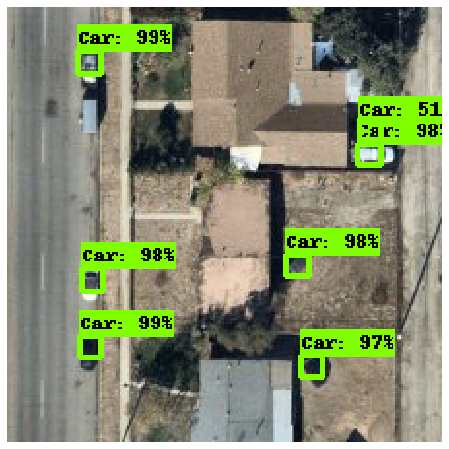

Time taken:  0.41251134872436523


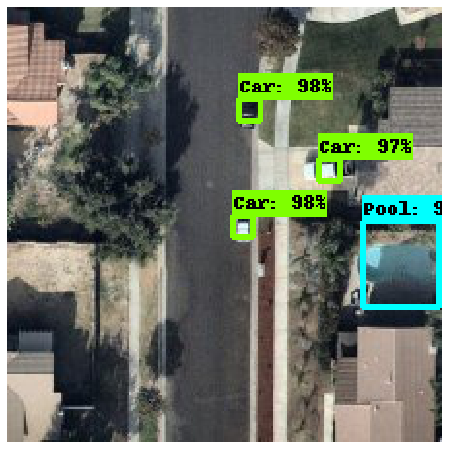

Time taken:  0.4350759983062744


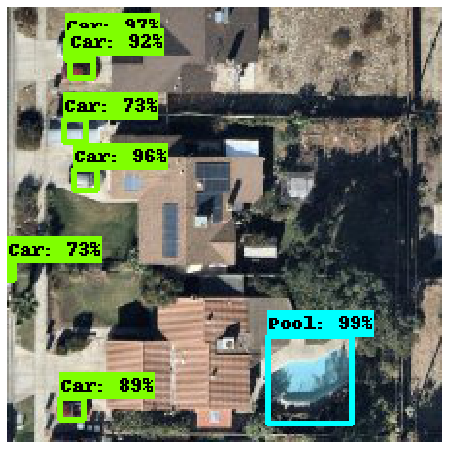

Time taken:  0.4083292484283447


In [0]:
inference_and_plot(detection_graph)

In [0]:
import collections

STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]

def visualize_boxes_and_labels_on_image_array(
    new_image,
    image,
    image_path,
    boxes,
    classes,
    scores,
    category_index,
    instance_masks=None,
    instance_boundaries=None,
    keypoints=None,
    use_normalized_coordinates=False,
    max_boxes_to_draw=20,
    min_score_thresh=.5,
    agnostic_mode=False,
    line_thickness=4,
    groundtruth_box_visualization_color='black',
    skip_scores=False,
    skip_labels=False):
  # Create a display string (and color) for every box location, group any boxes
  # that correspond to the same location.
  box_to_display_str_map = collections.defaultdict(list)
  clas = collections.defaultdict(list)
  sc = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  box_to_instance_masks_map = {}
  box_to_instance_boundaries_map = {}
  box_to_keypoints_map = collections.defaultdict(list)
  if not max_boxes_to_draw:
    max_boxes_to_draw = boxes.shape[0]
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if scores is None or scores[i] > min_score_thresh:
      box = tuple(boxes[i].tolist())
      if instance_masks is not None:
        box_to_instance_masks_map[box] = instance_masks[i]
      if instance_boundaries is not None:
        box_to_instance_boundaries_map[box] = instance_boundaries[i]
      if keypoints is not None:
        box_to_keypoints_map[box].extend(keypoints[i])
      if scores is None:
        box_to_color_map[box] = groundtruth_box_visualization_color
      else:
        display_str = ''
        if not skip_labels:
          if not agnostic_mode:
            if classes[i] in category_index.keys():
              class_name = category_index[classes[i]]['name']
            else:
              class_name = 'N/A'
            display_str = str(class_name)
          clas[box].append(int(classes[i]))
        if not skip_scores:
          if not display_str:
            display_str = '{}%'.format(int(100*scores[i]))
          else:
            display_str = '{}: {}%'.format(display_str, int(100*scores[i]))
        box_to_display_str_map[box].append(display_str)
        sc[box].append(scores[i])
        if agnostic_mode:
          box_to_color_map[box] = 'DarkOrange'
        else:
          box_to_color_map[box] = STANDARD_COLORS[classes[i] % len(STANDARD_COLORS)]      
      
  width, height = new_image.size
#   for box, color in box_to_color_map.items():
    
#     ymin, xmin, ymax, xmax = box
#     ymin = ymin*height
#     xmin = xmin*width
#     ymax = ymax*height
#     xmax = xmax*width
#     print('{} {} {} {} {} {}'.format(clas[box][0], sc[box][0], ymin, xmin, ymax, xmax))
 
  out_file = open('/content/predictions/%s.txt'%(image_path.split('/')[-1].split('.')[0]), 'w')
  
  for box, color in box_to_color_map.items():

    ymin, xmin, ymax, xmax = box
    ymin = ymin*height
    xmin = xmin*width
    ymax = ymax*height
    xmax = xmax*width
    out_file.write('{} {} {} {} {} {}\n'.format(clas[box][0], sc[box][0], ymin, xmin, ymax, xmax))

  out_file.close()


In [0]:
def inference_and_plot(detection_graph):
    with detection_graph.as_default():
      with tf.Session(graph=detection_graph) as sess:
        
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for image_path in TEST_IMAGE_PATHS:
            
            start_time = time.time()
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})

            # Visualization of the results of a detection.
            visualize_boxes_and_labels_on_image_array(
                image,
                image_np,
                image_path,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=3)


In [0]:
%time inference_and_plot(detection_graph)

CPU times: user 5min 33s, sys: 47.9 s, total: 6min 21s
Wall time: 18min 8s


In [0]:
! cp -R "/content/predictions" "/content/drive/My Drive/Colab Notebooks/"

In [0]:
import shutil

shutil.rmtree('/content/predictions')
#shutil.rmtree('/content/data/new_weights')
#shutil.rmtree('/content/data/new_output_inference_graphs')

In [0]:
import os

os.mkdir('/content/predictions')
#os.mkdir('/content/data/new_weights')